# Tutorial 1: building an optical system and performing ray-traces.
In this tutorial, we will build a simple optical system consisting of a parabolic reflector.
After that, we will perform a ray-trace through the system and find the focus of the paraboloid reflector.
We start by importing relevant packages. 

It is expected that the `PyPO` fundamentals tutorial has been studied before starting this tutorial. If not, please have a look at the fundamentals tutorial first.

In [8]:
#%matplotlib notebook
# Uncomment for interactive plots when running the notebook!

import numpy as np

from PyPO.System import System
from PyPO.Enums import Projections, Units, Objects

s = System()

2025-08-28 14:58:13 - WARNING - System override set to True. 


We created an empty `System` object at the end of the previous block. Note that we received a warning saying that System override has been set to true. This is warning tells us that, if we pass reflector dictionaries with the same names, they will overwrite eachother. If, instead, we instantiate like `s = System(override=False)`, `PyPO` will not overwrite, but rather append the number of occurances to the duplicate name and not show the warning. 

Now, we can define a paraboloid reflector by filling a dictionary with relevant parameters. In this case, we name the paraboloid "primary". We choose to generate it using the focus and vertex co-ordinate of the paraboloid by choosing the "focus" option for the "pmode" (parameter mode) field. We choose a "uv" parametrisation for the "gmode" (grid mode) field. We then set "flip" to "False". We then specify the "vertex" and "focus_1" fields. Then we define the limits for "lims_u" and "lims_v". Finally we define the "gridsizes" field. These values are not important for ray-traces but have to be specified nonetheless. For physical optics, as we will see in a later tutorial, these values are critical for a good calculation.

After defining we can add the paraboloid to the `System` by passing the reflector dictionary to the `s.addParabola()` method.

2025-08-28 14:58:14 - INFO - Added paraboloid primary to system. 


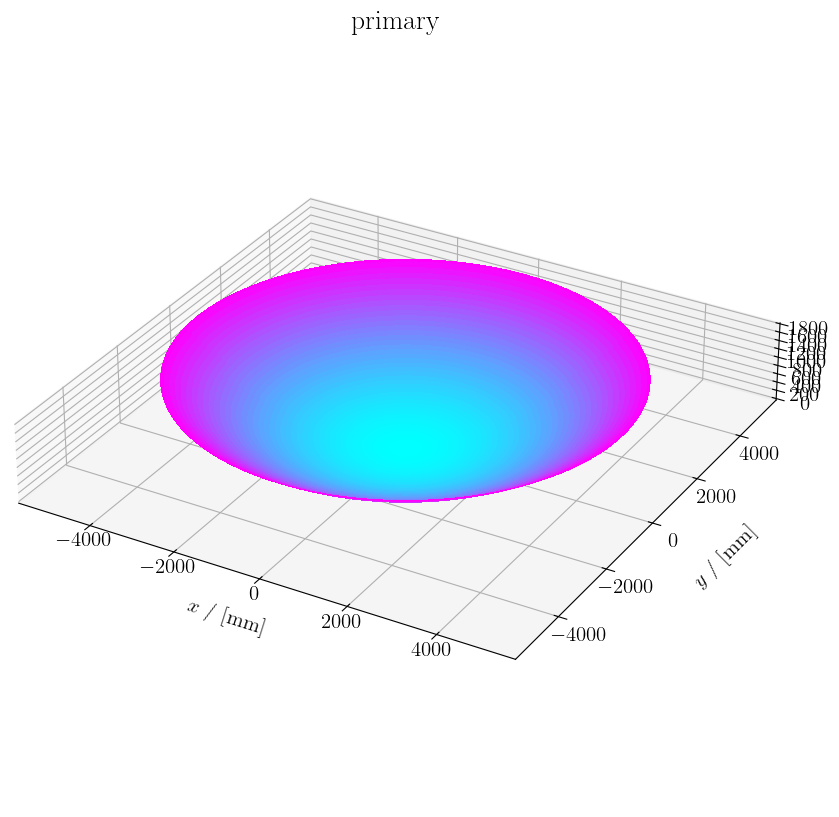

In [9]:
focus_parabola = np.array([0, 0, 3.5e3])

parabola = {
            "name"      : "primary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : False,
            "vertex"    : np.zeros(3),
            "focus_1"   : focus_parabola,
            "lims_u"    : np.array([0, 5e3]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([801, 800])
            }

s.addParabola(parabola)

s.plot3D("primary", norm=True)


After adding the paraboloid we plot the reflector using the `s.plot3D()` function. This method takes as positional argument the name of the reflector to plot. We also set "norm" = "True". This also plots the normal vectors to the reflector.
Now that we have an optical element, we can proceed and perform a ray-trace through the system. 

We start by defining an initial frame of rays above the paraboloid we just made.

2025-08-28 14:58:32 - INFO - Added tubular frame start to system. 


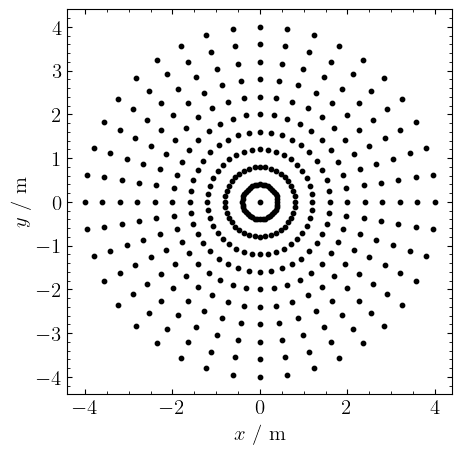

2025-08-28 14:58:32 - INFO - Translated frame start by ('0.000e+00', '0.000e+00', '3.500e+03') millimeters. 


In [10]:
RTpar = {
        "name"      : "start",
        "nRays"     : 10,
        "nRing"     : 10,
        "angx0"     : 0,
        "angy0"     : 0,
        "x0"        : 4000,
        "y0"        : 4000
        }

s.createTubeFrame(RTpar)
s.plotRTframe("start", units=Units.M)
s.translateGrids("start", np.array([0, 0, 3.5e3]), obj=Objects.FRAME)

We made a tubular ray-trace frame consisting of an annular distribution of rings containing rays. This type of frame can be used to simulate point sources, collimated beams and anything in between. However, for quantitative analysis this model is not the best, because ray-tracing does not model collimated beams or point-sources well. In a later tutorial, we will investigate another model which is more appropriate for this end. 

Adding frames to the system is also done by specifying a dictionary, the frame dictionary in this case. The first field is the name of the frame. This name is the way whe can interact with this frame through the system object. The next field is the number of rays per annular ring. Note that the total amount of rays in a ring will be a multiple of four of the specified "nRays" in the field. The next field, "nRing", specifies the total amount of annular rings. The next two fields, "angx0" and "angy0", specify the opening angles along the x- and y-axes, in degrees. The opening angle will vary smoothly over an annulus, reaching the specified angles at the outer annulus. The last two fields, "x0" and "y0", specify radius of the outer annulus. If "x0" is unequal to "y0", the annular rings will be ellipses.

As mentioned, the name of the frame will be the main way of interacting with the frame object, which is stored in the `System` object, inside the internal frame dictionary. We translate the frame to the focal plane of the paraboloid. 

To inspect a frame, we can call the `s.plotRTframe()` method, passing the name of the frame as an argument. We also fill the "units" parameter with `Units.M`, which means we plot the axes in units of meters. The `Units` module in `PyPO` is an Enum object. In `PyPO`, it is often necessary to pass arguments to functions that determine what component of a field is taken, what unit to plot an axis in, what projection to plot, etc. These could be passed as strings, but it is safer to use the Enum type to do this because the type itself now guarantees that options are taken from a few possibilities.

We then propagate the initialised frame to the paraboloid:

2025-08-28 14:58:34 - WORK - *** Starting RT propagation *** 
2025-08-28 14:58:34 - WORK - Hardware: running 15 CPU threads. 
2025-08-28 14:58:34 - WORK - ... Calculating ... 
2025-08-28 14:58:34 - WORK - *** Finished: 0.008 seconds *** 


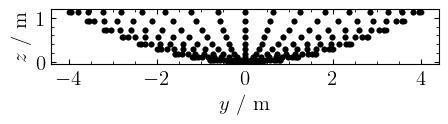

In [11]:
start_pri_RT = {
            "fr_in"     : "start",
            "t_name"    : "primary",
            "fr_out"    : "fr_pri",
            "device"    : "CPU",
            "tol"       : 1e-16
            }

s.runRayTracer(start_pri_RT)
s.plotRTframe("fr_pri", project=Projections.yz, units=Units.M)

The ray-trace itself is done, again, using a dictionary. This time, we specify the initial frame using the "fr_init" field. Then, we specify the target surface using "t_name". We specify the name of the output frame using "fr_out". We can also specify the device on which the calculation is performed. We use "CPU" in this case. Note that if "GPU" is selected, CUDA should be installed. If "GPU" is specified and no CUDA is installed, PyPO defaults to the CPU. The last field is the tolerance "tol" for the ray-tracer. Thus number determines how precise the ray-tracer will calculate the ray-surface intersection.

The ray-trace is done by first transforming the target surface back into its own restframe. The input frame is transformed by the same amount. Then, the actual ray-trace is performed in the transformed co-ordinate system. After the ray-trace, both the reflector and frame are transformed back to their original configurations.

After running, we plot the frame on the paraboloid. We pass `Projections.yz` as "project", which plots the frame with y as abscissa and z as ordinate. This confirms that the frame is indeed defined on the paraboloid.

Note also that `PyPO` uses different logging colors for different pruposes. General information, such as when a new reflector is created or when a reflector is transformed, are colored green and are called "INFO". Information about calculations, such as ray-tracing, is logged using blue and labelled by "WORK". A result of a calculation is logged in purple and labelled "RESULT". A warning is logged in yellow (as we saw before) and labelled a "WARNING". Finally, an error is logged in red and aptly labelled "ERROR".

Now, we will propagate the rays to the focus of the paraboloid. We make a plane and translate it to the focus. The limits and gridsize do not really matter, as the ray-tracer works with the mathematical description of the plane, not the gridparameters.

2025-08-28 14:58:36 - INFO - Added plane focal_plane to system. 
2025-08-28 14:58:36 - INFO - Translated element focal_plane by ('0.000e+00', '0.000e+00', '3.500e+03') millimeters. 
2025-08-28 14:58:36 - WORK - *** Starting RT propagation *** 
2025-08-28 14:58:36 - WORK - Hardware: running 15 CPU threads. 
2025-08-28 14:58:36 - WORK - ... Calculating ... 
2025-08-28 14:58:36 - WORK - *** Finished: 0.010 seconds *** 


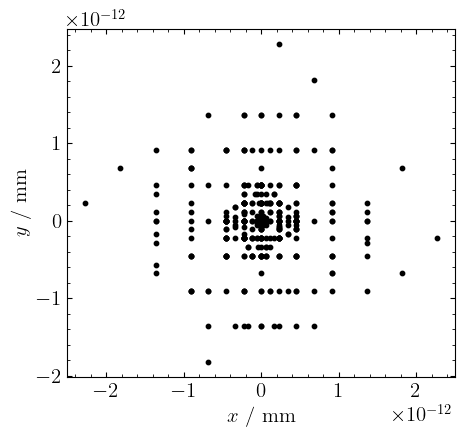

In [12]:
focal_plane = {
            "name"      : "focal_plane",
            "gmode"     : "xy",
            "lims_x"    : np.array([-1, 1]),
            "lims_y"    : np.array([-1, 1]),
            "gridsize"  : np.array([101, 101])
            }

s.addPlane(focal_plane)
s.translateGrids("focal_plane", focus_parabola)

pri_focus_RT = {
            "fr_in"     : "fr_pri",
            "t_name"    : "focal_plane",
            "fr_out"    : "fr_focus",
            "tol"       : 1e-12
            }

s.runRayTracer(pri_focus_RT)
s.plotRTframe("fr_focus")

We can see that the ray-tracer works as expected. Rays coming in a collimated beam from infinity are focussed into a very tight spot. Since the scale is in millimeter, the size of the spot is on the order of $10^{-15}$ meter, which is completely unphysical. This is a good demonstration of the limitations of geometrical optics close to focii and caustics. 

We can also try to find the focus of the paraboloid using an optimisation procedure.

2025-08-28 14:58:37 - INFO - Added plane focal_plane_fr_pri to system. 
2025-08-28 14:58:37 - INFO - Translated element focal_plane_fr_pri by ('-7.711e-14', '4.536e-15', '4.389e+02') millimeters. 
2025-08-28 14:58:37 - WORK - Finding focus of fr_pri... 
2025-08-28 14:58:37 - RESULT - Focus of frame fr_pri: ('2.130e-14', '8.815e-15', '3.500e+03'), RMS: 2.076e-12 


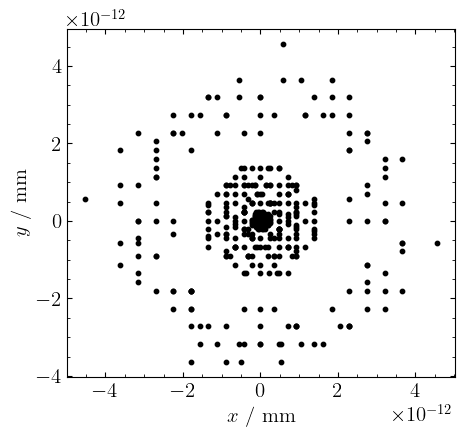

In [13]:
s.findRTfocus("fr_pri", tol=1e-12)
s.plotRTframe("focus_fr_pri", units=Units.MM)

The `s.findRTfocus()` method takes as argument the name of the frame of which the focus needs to be found. At the end of the call, it places the focus frame in the system. The name of this new frame will be the name of the frame passed as argument, prepended by "focus_". Also, the plane corresponding to the focus is stored in the system. The name of the plane is the name of the input frame, prepended by "focal_plane_". 

We can see that the spot found by this method is slightly bigger (factor ~2) than the spot we found by directly using the paraboloid focus. Nevertheless, it is still very small. Therefore, if the focus is known, it is better to use the focus. If the focus is not know, the `s.findRTfocus()` method can be used.

We again run the `s.plotSystem()` method, but this time we pass an extra argument "RTframes". This is a list of frame names in the internal frame dictionary that we would like to plot. The `s.plotSystem()` method then connects the rays in each frame and draws lines between them. This makes it easier to visualise the path of the rays between frames.

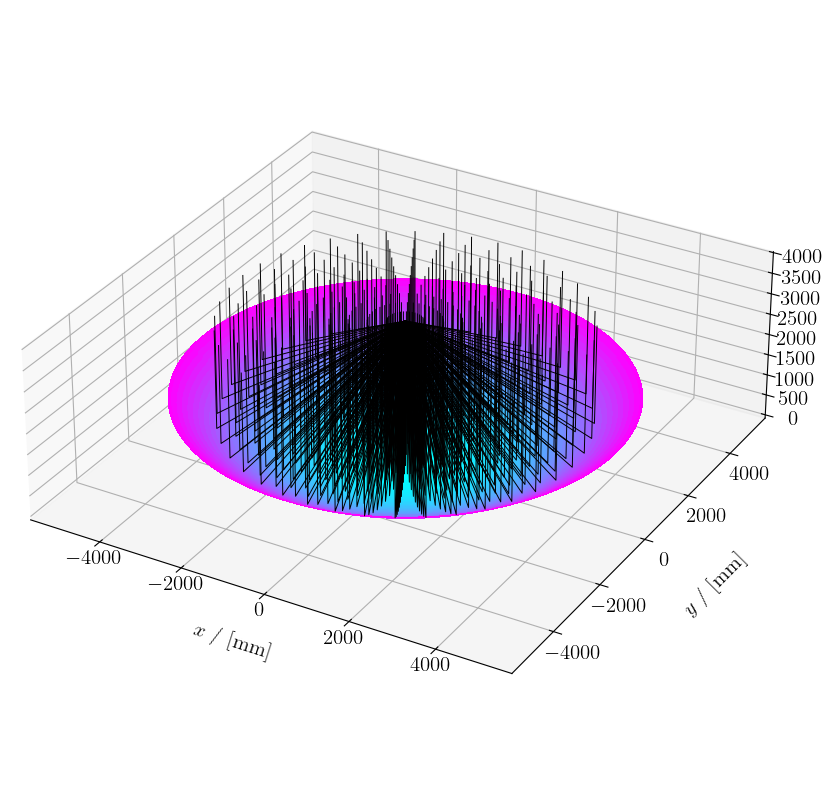

In [14]:
s.plotSystem(RTframes=["start", "fr_pri", "fr_focus"])